# init

**Data Pre-processing**
- 2011-2018 (8 years) . CC before 2011 has no indicator of the MD and QA parts.
- for 2012-2018, ~98% have MD/QA indicators; for 2011, ~93% has MD/QA

In [3]:
# library
library(feather)
library(stringdist)
library(tools)
library(pdftools)
options('sd_num_thread'=8)

# data_dir
DATA_DIR = "C:/Users/rossz/OneDrive/CC/data"
WRDS_DOWNLOAD_DIR = str_c(DATA_DIR, '/WRDS-download')

# WRDS

## establish connection

In [1]:
library(RPostgres)

# connect to wrds
wrds <- dbConnect(Postgres(),
                  host='wrds-pgdata.wharton.upenn.edu',
                  port=9737,
                  dbname='wrds',
                  sslmode='require',
                  user='xiaomowu',
                  password='SLCyz2018')

## unit test

In [17]:
# Determine the data libraries available at WRDS
res <- dbSendQuery(wrds, "select distinct table_schema
                   from information_schema.tables
                   where table_type ='VIEW'
                   or table_type ='FOREIGN TABLE'
                   order by table_schema")
data <- dbFetch(res, n=-1)
dbClearResult(res)
print(setDT(data)[, sort(table_schema)])

  [1] "aha"                "ahasamp"            "audit"             
  [4] "blab"               "block"              "boardex"           
  [7] "boardsmp"           "bvd"                "bvdsamp"           
 [10] "calcbnch"           "cboe"               "centris"           
 [13] "ciq"                "ciqsamp"            "cisdm"             
 [16] "clrvt"              "clrvtsmp"           "comp"              
 [19] "compa"              "compb"              "compdcur"          
 [22] "compg"              "comph"              "compm"             
 [25] "compmcur"           "compsamp"           "compseg"           
 [28] "compsnap"           "comscore"           "contrib"           
 [31] "crsp"               "crspa"              "crspm"             
 [34] "crspq"              "crspsamp"           "csmar"             
 [37] "dealscan"           "djones"             "dmef"              
 [40] "doe"                "emdb"               "etfg"              
 [43] "etfgsamp"           "eureka

In [6]:
# Determine the datasets within a given library
library = 'comp'
res <- dbSendQuery(wrds, sprintf("select distinct table_name
                   from information_schema.columns
                   where table_schema='%s'
                   order by table_name", library))
data <- dbFetch(res, n=-1)
dbClearResult(res)
setDT(data)[, sort(table_name)] %>% print()

  [1] "aco_amda"          "aco_imda"          "aco_indfnta"      
  [4] "aco_indfntq"       "aco_indfntytd"     "aco_indsta"       
  [7] "aco_indstq"        "aco_indstytd"      "aco_notesa"       
 [10] "aco_notesq"        "aco_notessa"       "aco_notesytd"     
 [13] "aco_pnfnda"        "aco_pnfndq"        "aco_pnfndytd"     
 [16] "aco_pnfnta"        "aco_pnfntq"        "aco_pnfntytd"     
 [19] "aco_transa"        "aco_transq"        "aco_transsa"      
 [22] "aco_transytd"      "adsprate"          "anncomp"          
 [25] "asec_amda"         "asec_imda"         "asec_notesa"      
 [28] "asec_notesq"       "asec_transa"       "asec_transq"      
 [31] "bank_aacctchg"     "bank_adesind"      "bank_afnd1"       
 [34] "bank_afnd2"        "bank_afnddc1"      "bank_afnddc2"     
 [37] "bank_afntind"      "bank_funda"        "bank_funda_fncd"  
 [40] "bank_fundq"        "bank_fundq_fncd"   "bank_iacctchg"    
 [43] "bank_idesind"      "bank_ifndq"        "bank_ifndytd"     
 [46] "ban

In [ ]:
# Determine the variables (column headers) within a given dataset
library = 'ibes'
dataset = 'det_epsus'
res <- dbSendQuery(wrds, sprintf("select column_name
                   from information_schema.columns
                   where table_schema='%s'
                   and table_name='%s'
                   order by column_name", library, dataset))
data <- dbFetch(res, n=-1)
dbClearResult(res)
setDT(data)[, column_name] %>% print()

In [ ]:
# To query the crsp.dsf dataset
library = "ibes"
dataset = 'ptgdet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
data <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
nrow(data)

## I/B/E/S

### Detail

In [ ]:
library = 'ibes'
dataset = 'det_epsus' # eps
# dataset = 'det_xepsus' # non-eps
years = 2000:2018

for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(anndats,'yyyy')='%s'", library, dataset, year)
    save_name_short = sprintf('%s_%s_%s', library, dataset, year)
    save_name_full = sprintf('../data/WRDS-download/%s_%s_%s.rds', library, dataset, year)
    
    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    assign(save_name_short, data)
    sprintf('%s_%s: %s', dataset, year, nrow(data))
    saveRDS(data, save_name_full)
}

In [53]:
data[1]

ticker,cusip,oftic,cname,actdats,estimator,analys,currfl,pdf,fpi,measure,value,curr,usfirm,fpedats,acttims,revdats,revtims,anndats,anntims,actual,actdats_act,acttims_act,anndats_act,anntims_act,curr_act,report_curr
INTC,45814010,INTC,INTEL CP,2001-01-12,471,22336,NA,D,1,EPS,1.55,NA,1,2000-12-31,48822,2001-01-12,48858,2001-01-12,48614,1.645,2001-01-16,59880,2001-01-16,59760,USD,USD


### Summary

In [9]:
library = 'ibes'
dataset = 'statsum_epsus' # summary eps
query = sprintf("select * from %s.%s", library, dataset)

res <- dbSendQuery(wrds, query)
ibes_statsum_epsus <- setDT(dbFetch(res, n=-1)); dbClearResult(res)

ibes_statsum_epsus[1]
sv(ibes_statsum_epsus, path=WRDS_DOWNLOAD_DIR)

-statsum_epsus- saved  (43.43 secs)


In [ ]:
library = 'ibes'
dataset = 'statsum_xepsus' # summary xeps

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_statsum_xepsus <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
ibes_statsum_xepsus[1]
sv(ibes_statsum_xepsus, path=WRDS_DOWNLOAD_DIR)

### Surprise

In [ ]:
library = 'ibes'
dataset = 'surpsum' # summary surprise 

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_surpsum <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
ibes_surpsum[1]
sv(ibes_surpsum, path=WRDS_DOWNLOAD_DIR)

## price target

In [ ]:
library = "ibes"
dataset = 'ptgdet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
ptgdet <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
sv(ptgdet, path='/data/WRDS-download')

In [6]:
nrow(ptgdet)

[1] 5245752

In [5]:
ptgdet[1]

ticker,cusip,oftic,cname,actdats,estimid,alysnam,horizon,value,estcur,curr,amaskcd,usfirm,measure,acttims,anndats,anntims
0000,87482X10,TLMR,TALMER BANCORP,2014-03-10,PRMDN082,PERMDENIED,12,16,USD,USD,538750,1,PTG,32043,2014-03-10,1200


## recommend

In [ ]:
library = 'ibes'
dataset = 'recddet'
res <- dbSendQuery(wrds, sprintf("select * from %s.%s", library, dataset))
recddet <- dbFetch(res, n=-1) %>% setDT()
dbClearResult(res)
sv(recddet, path='/data/WRDS-download')

In [7]:
nrow(recddet)

[1] 2812735

In [8]:
recddet[1]

ticker,cusip,cname,oftic,actdats,estimid,analyst,ereccd,etext,ireccd,itext,emaskcd,amaskcd,usfirm,acttims,revdats,revtims,anndats,anntims
0000,87482X10,TALMER BANCORP,TLMR,2014-03-10,PRMDN082,PERMDENIED,2,OUTPERFORM,2,BUY,50659,538750,1,32043,2016-01-26,34552,2014-03-10,1200


## stock price

In [ ]:
library = 'comp'
dataset = 'secd' # factors
years = 2000:2018

system.time({
secd = list()
for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(datadate,'yyyy')='%s'", library, dataset, year)

    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    print(sprintf('%s_%s: %s obs', dataset, year, nrow(data)))
    secd[[as.character(year)]] = data
}
secd = rbindlist(secd, use=T)
})
sv(secd, path=WRDS_DOWNLOAD_DIR)

Download `CRSP`
It's *deprecated*!

In [ ]:
library = 'crspq'
dataset = 'dsf' # factors
years = 2001:2018

for (year in years) {
    print(sprintf('Start %s at %s', year, now()))
    query = sprintf("select * from %s.%s where to_char(date,'yyyy')='%s'", library, dataset, year)
    save_name_short = sprintf('%s_%s', dataset, year)
    save_name_full = sprintf('../data/WRDS-download/%s_%s.rds', dataset, year)

    res <- dbSendQuery(wrds, query)
    data <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
    
    sprintf('%s_%s: %s', dataset, year, nrow(data))
    assign(save_name_short, data)
    saveRDS(data, save_name_full)
}

In [31]:
ld(dsf_2001, path=WRDS_DOWNLOAD_DIR)

-dsf_2001- loaded  (1.11 secs)


In [32]:
dsf_2001[1]

cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
36720410,10001,7953,10398,2,4925,2001-01-02,9.3125,9.875,9.875,3849,0.01282051,9.5,9.875,2498,1.5,1.5,9.3125,9,0.01282051


## factors

In [7]:
library = 'ff'
dataset = 'factors_daily' # factors

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
factors <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(data))
sv(factors, path='/data/WRDS-download')

[1] "factors_daily: 1860532"

-factors- saved  (0.09 secs)


In [6]:
factors[1]

date,mktrf,smb,hml,rf,umd
1926-07-01,0.001,-0.0024,-0.0028,9e-05,NA


## firm-id

### `ibes.id`

In [4]:
library = 'ibes'
dataset = 'id' # firm names

query = sprintf("select ticker, cusip, cname, sdates from %s.%s where usfirm=1 and cusip != ''", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_id <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(ibes_id))
sv(ibes_id, path=WRDS_DOWNLOAD_DIR)

query = sprintf("select ticker, cusip, cname, oftic, sdates from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ibes_id2 <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ibes_id2))

ibes_id2[1]
sv(ibes_id2, path=WRDS_DOWNLOAD_DIR)

[1] "nrow: 86242"

-ibes_id- saved  (0.15 secs)


[1] "id: 240098"

ticker,cusip,cname,oftic,sdates
0000,87482X10,TALMER BANCORP,TLMR,2014-02-20


-ibes_id2- saved  (0.54 secs)


### `comp.security`
The table being used:
- `comp_security`: link I/B/E/S to Compustat

In [391]:
library = 'compm'
dataset = 'security' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_security <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(comp_security))

comp_security[1]
sv(comp_security, path=WRDS_DOWNLOAD_DIR)

[1] "security: 58376"

tic,gvkey,iid,cusip,dlrsni,dsci,epf,exchg,excntry,ibtic,isin,secstat,sedol,tpci,dldtei
AE.2,001000,01,000032102,09,COM USD1,NA,12,USA,NA,NA,I,NA,0,1978-06-30


-comp_security- saved  (0.34 secs)


### `crsp.stocknames`

In [88]:
library = 'crsp'
dataset = 'stocknames' # firm names

query = sprintf("select permno, ncusip, comnam, namedt, nameenddt from %s.%s where ncusip != ''", library, dataset)
res <- dbSendQuery(wrds, query)
crsp_stocknames <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(crsp_stocknames))
sv(crsp_stocknames, path=WRDS_DOWNLOAD_DIR)

query = sprintf("select ticker, comnam, permno, ncusip, namedt, nameenddt from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
crsp_stocknames2 <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('nrow: %s', nrow(crsp_stocknames2))
crsp_stocknames2[1]
sv(crsp_stocknames2, path=WRDS_DOWNLOAD_DIR)

[1] "stocknames: 55738"

permno,ncusip,comnam,namedt,nameenddt
10000,68391610,OPTIMUM MANUFACTURING INC,1986-01-07,1987-06-11


-crsp_stocknames- saved  (0.17 secs)


## index-constituent

In [63]:
ld(comp_idx_prof, path=WRDS_DOWNLOAD_DIR)
ld(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)
ld(comp_security, path=WRDS_DOWNLOAD_DIR)
ld(crsp_stocknames, path=WRDS_DOWNLOAD_DIR)

-comp_idx_prof- already exists, will NOT load again!  (0 secs)
-comp_idx_cst- already exists, will NOT load again!  (0 secs)
-comp_security- already exists, will NOT load again!  (0 secs)
-crsp_stocknames- already exists, will NOT load again!  (0 secs)


In [74]:
x = unique(comp_idx_cst[gvkeyx=='000005'
    ][comp_security[, .(gvkey, iid, tic, cusip=str_sub(cusip, 1, 6), sedol)], 
      on=.(gvkey, iid), nomatch=0])
x
# x[1]
# crsp_stocknames[1]
# y = x[crsp_stocknames[, .(cusip=str_sub(ncusip, 1, 6), comnam)], on=.(cusip)]
# y[1]

gvkey,iid,gvkeyx,from,thru,tic,cusip,sedol
001300,01,000005,1925-12-07,2008-02-18,HON,438516,2020459
001356,01,000005,1959-06-01,2013-09-22,AA.3,013817,BYVZDB3
001447,01,000005,1982-08-30,NA,AXP,025816,2026082
001487,01,000005,2004-04-08,2008-09-21,AIG,026874,2027342
001581,01,000005,1939-03-14,2004-04-07,T.2,001957,2064888
001690,01,000005,2015-03-19,NA,AAPL,037833,2046251
002136,01,000005,2004-04-08,NA,VZ,92343V,2090571
002285,01,000005,1987-03-12,NA,BA,097023,2108601
002817,01,000005,1991-05-06,NA,CAT,149123,2180201
002968,01,000005,2001-01-02,NA,JPM,46625H,2190385


In [12]:
library = 'compa'
dataset = 'idx_index' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_idx_prof <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(comp_idx_prof))

comp_idx_prof[1]
sv(comp_idx_prof, path=WRDS_DOWNLOAD_DIR)

[1] "idx_index: 2133"

conm,gvkeyx,idx13key,idxcstflg,idxstat,indexcat,indexgeo,indexid,indextype,indexval,spii,spmi,tic,tici
S&P Industrials-Wed,000001,0000000000000,N,A,S&P,USA,500,LGCAP,000000000,NA,NA,I0001,I0001


-comp_idx_prof- saved  (0.03 secs)


In [16]:
library = 'compa'
dataset = 'idxcst_his' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
comp_idx_cst <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(comp_idx_cst))

comp_idx_cst[1]
sv(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)

[1] "idxcst_his: 87146"

gvkey,iid,gvkeyx,from,thru
001004,01,030824,1994-10-01,NA


-comp_idx_cst- saved  (0.18 secs)


## keydev

In [30]:
library = 'ciq'
dataset = 'wrds_keydev' # everything except for `headline` and `situation`

query = sprintf("select * from %s.%s 
    where keydeveventtypeid in (28, 48, 55, 61, 144)", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_wrds_keydev <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_wrds_keydev))

# `mostimportantdateutc` is in UTC but R doesn't recognize,
# so we need to set it explictly
ciq_wrds_keydev[, ':='(mostimportantdateutc=force_tz(mostimportantdateutc, 'UTC'))]

sv(ciq_wrds_keydev, path=WRDS_DOWNLOAD_DIR)

[1] "wrds_keydev: 1"

In [ ]:
library = 'ciq'
dataset = 'ciqkeydev' # `headline` and `situation`

query = sprintf("select * from %s.%s 
    where keydevid in 
        (select keydevid from ciq.wrds_keydev
        where keydeveventtypeid in (28, 48, 55, 61, 144))",
    library, dataset)
res <- dbSendQuery(wrds, query)
ciq_keydev <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_keydev))

# `mostimportantdateutc` is in UTC but R doesn't recognize,
# so we need to set it explictly
ciq_keydev[, ':='(mostimportantdateutc=force_tz(mostimportantdateutc, 'UTC'))]

sv(ciq_keydev, path=WRDS_DOWNLOAD_DIR)

# Parse CC

## `ICLINK`

More explanation on score system:
- 0: BEST match: using (cusip, cusip dates and company names)       
          or (exchange ticker, company names and 6-digit cusip)     
- 1: Cusips and cusip dates match but company names do not match    
- 2: Cusips and company names match but cusip dates do not match    
- 3: Cusips match but cusip dates and company names do not match    
- 4: tickers and 6-digit cusips match but company names do not match   
- 5: tickers and company names match but 6-digit cusips do not match       
- 6: tickers match but company names and 6-digit cusips do not match  

### Link by `CUSIP`

**1.1 IBES: Get the list of IBES Tickers for US firms in IBES**

In [9]:
ld(ibes_id, path=WRDS_DOWNLOAD_DIR, force=T)

ibes_id = ibes_id[, ':='(fdate=min(sdates), ldate=max(sdates)), 
     keyby=.(ticker, cusip)
    ][order(ticker, cusip, sdates)
    ][sdates==ldate
    ][, .(ticker, cusip, cname, fdate, ldate)]
ibes_id[1]

-ibes_id- loaded  (0.08 secs)


ticker,cusip,cname,fdate,ldate
0000,87482X10,TALMER BANCORP,2014-02-20,2014-03-20


**1.2 CRSP: Get all permno-ncusip combinations**

In [10]:
ld(crsp_stocknames, path=WRDS_DOWNLOAD_DIR, force=T)

crsp_stocknames = crsp_stocknames[, ':='(enddt=nameenddt)
    ][, ':='(namedt=min(namedt), nameenddt=max(nameenddt)), 
     keyby=.(permno, ncusip)
    ][enddt==nameenddt
    ][, ':='(enddt=NULL)]

-crsp_stocknames- loaded  (0.05 secs)


**1.3 Create CUSIP Link Table**

In [11]:
# Link by full cusip, company names and dates
# Keep link with most recent company name

cusip_link = crsp_stocknames[ibes_id, on=c('ncusip==cusip'), nomatch=0
    ][order(ticker, permno, -ldate),
    ][, .SD[1], keyby=.(ticker, permno)
    ][, ':='(name_ratio=stringsim(comnam, cname))]

In [12]:
# Calculate name matching ratio using

name_ratio_p10 = quantile(cusip_link$name_ratio, 0.1)

cusip_link = cusip_link[, ':='(score=ifelse((fdate<nameenddt) & (ldate>namedt) & (name_ratio>name_ratio_p10), 0, 
    ifelse((fdate<nameenddt) & (ldate>namedt), 1, 
    ifelse(name_ratio>name_ratio_p10, 2, 3))))
    ][, .(ticker, permno, cname, comnam, name_ratio, score)] %>% unique()

### Link by Ticker

**Find links for the remaining unmatched cases using Exchange Ticker**

In [29]:
# Identify remaining unmatched cases 
# Add IBES identifying information

# Create first and last 'start dates' for Exchange Tickers
# Label date range variables and keep only most recent company name

ld(ibes_id2, path=WRDS_DOWNLOAD_DIR)

nomatch = unique(cusip_link[, .(permno, ticker)
    ][ibes_id[, (ticker)], on=.(ticker), nomatch=NA
    ][is.na(permno)])[, ':='(permno=NULL)
    ][ibes_id2[!is.na(oftic)], on=.(ticker), nomatch=0
    ][, ':='(fdate=min(sdates), ldate=max(sdates)), 
     keyby=.(ticker, oftic)
    ][sdates==fdate]
nrow(nomatch)

-ibes_id2- already exists, will NOT load again!  (0 secs)


[1] 8287

In [45]:
# Get entire list of CRSP stocks with Exchange Ticker information
# Arrange effective dates for link by Exchange Ticker

# Merge remaining unmatched cases using Exchange Ticker 
# Note: Use ticker date ranges as exchange tickers are reused overtime

# Score using company name using 6-digit CUSIP and company name spelling distance

ld(crsp_stocknames2, path=WRDS_DOWNLOAD_DIR)

cusip_link2 = crsp_stocknames2[!is.na(ticker)
    ][order(permno, ticker, namedt)
    ][, ':='(namedt_ind=namedt, nameenddt_ind=nameenddt)
    ][, ':='(namedt=min(namedt), nameenddt=max(nameenddt)), keyby=.(permno, ticker)
    ][nameenddt_ind==nameenddt
    ][, .(crsp_ticker=ticker, comnam, permno, ncusip, namedt, nameenddt)
    ][nomatch, on=c('crsp_ticker==oftic'), nomatch=0
    ][ldate>namedt & fdate<nameenddt
    ][, ':='(name_ratio=stringsim(comnam, cname), 
             cusip6=str_sub(cusip, 1, 6),
             ncusip6=str_sub(ncusip, 1, 6))
    ][, ':='(score=ifelse(cusip6==ncusip6 & name_ratio>name_ratio_p10, 0,
     ifelse(cusip6==ncusip6, 4,
     ifelse(name_ratio>name_ratio_p10, 5, 6))))]

cusip_link2[, .N]

-crsp_stocknames2- already exists, will NOT load again!  (0 secs)


[1] 305

## `cc_transcript`

Unit test

In [453]:
path = 'C:/Users/rossz/OneDrive/CC/data/ciq-transcripts/ciq-sp500-2018-0201-0400/cc_2018/ETRADE Financial Corporation, Q4 2017 Earnings Call, Jan 25, 2018.pdf'
cc = pdf_text(path)
n_page = length(cc)

str_sub(cc[n_page], 1, 100)
header = str_extract(cc[n_page], '^.+(\\r\\n)*20\\d{2}\\r\\n')
header
cc = str_replace_all(cc, fixed(header), '')
str_sub(cc[5], 1, 100)

[1] "E*TRADE FINANCIAL CORPORATION FQ4 2017 EARNINGS CALL | JAN 25, 2018\r\nCopyright © 2019 by S&P Global "

[1] "E*TRADE FINANCIAL CORPORATION FQ4 2017 EARNINGS CALL | JAN 25, 2018\r\n"

[1] "Presentation\r\nOperator\r\nGood evening, and thank you for joining E*TRADE's Fourth Quarter and Full Ye"

load data

In [1]:
cc_paths = list.files(
    'C:/Users/rossz/OneDrive/CC/data/ciq-transcripts',
    recursive=T,
    pattern='.pdf$',
    full=T)
cat('N of all transcripts:', length(cc_paths), '\n')

cc_paths = cc_paths[str_detect(cc_paths, regex('Earnings', ignore=T))]
cat('N of Earnings Call:', length(cc_paths), '\n')

N of all transcripts: 6478 
N of Earnings Call: 2917 


In [4]:
parse_one_page <- function(cc_path) {
    obs = list()
    
    cc = pdf_text(cc_path)
    n_page = length(cc)
    
    # cc_filename
    cc_filename = str_match(
        cc_path,
        regex('/([^/]+?)\\.pdf', ignore=T))[,2]
    
    # remove header
    header = str_extract(cc[n_page], '^.+(\\r\\n)*20\\d{2}\\r\\n')
    cc = str_replace_all(cc, fixed(header), '')
    
    # remove footer
    cc = str_replace_all(cc, '\\r\\n.+\\r\\n.+\\r\\n$', '')
    
    # determin which page is TOC
    toc_pagenum = str_which(cc, regex('contents[\\s\\S]+table of contents', ignore=T))
    if (length(toc_pagenum) > 1) {
        stop('len(toc_pagenum) > 1 !!')
    }
    
    # extract pagenum
    toc_page = cc[toc_pagenum]
    toc_participants = str_match(
        toc_page, 
        regex('contents[\\s\\S]+table of contents[\\s.]+(call participants.+)?', ignore=T))[,2]
    participants_pagenum = as.integer(str_match(toc_participants, '[\\. ]+(\\d+)')[,2])
    
    toc_md = str_match(
        toc_page,
        regex('contents[\\s\\S]+table of contents[\\s\\S]+(presentation.+)', ignore=T))[,2]
    md_pagenum = as.integer(str_match(toc_md, '[\\. ]+(\\d+)')[,2])
    
    toc_qa = str_match(
        toc_page,
        regex('contents[\\s\\S]+table of contents[\\s\\S]+(question and answer.+)', ignore=T))[,2]
    qa_pagenum = as.integer(str_match(toc_qa, '[\\. ]+(\\d+)')[,2])
    
    # extract {md, qa}
    if (!is.na(qa_pagenum)) {
        md = str_c(cc[md_pagenum:(qa_pagenum-1)], collapse=' ') %>% str_replace_all('\\r\\n', ' ')
        qa = str_c(cc[qa_pagenum:(n_page-1)], collapse='') %>% str_replace_all('\\r\\n', ' ')

        # test if `md` and `qa` parsed successfully
        # if failed, parse again
        if ((str_sub(md, 1, 12) != 'Presentation') | (str_sub(qa, 1, 19) != 'Question and Answer')) {
            md_pagenum = str_which(cc, '^Presentation')
            qa_pagenum = str_which(cc, '^Question and Answer')
            
            md = str_c(cc[md_pagenum:(qa_pagenum-1)], collapse='') %>% str_replace_all('\\r\\n', ' ')
            qa = str_c(cc[qa_pagenum:(n_page-1)], collapse='') %>% str_replace_all('\\r\\n', ' ')
            
            if ((str_sub(md, 1, 12) != 'Presentation') | (str_sub(qa, 1, 19) != 'Question and Answer')) {
                cat('MD/QA parsing error!:', cc_path, '\n')
                cat('\t MD:', str_sub(md, 1, 13), '\n')
                cat('\t QA:', str_sub(qa, 1, 20), '\n')
#                 cat('\t New MD:', str_sub(md, 1, 13), '\n')
#                 cat('\t New QA:', str_sub(qa, 1, 20), '\n')
            }

        }
        
    } else {
        md = str_c(cc[md_pagenum:(n_page-1)], collapse=' ') %>% str_replace_all('\\r\\n', ' ')
        qa = NA
        if (str_sub(md, 1, 12) != 'Presentation') {
            md_pagenum = str_which(cc, '^Presentation')
            md = str_c(cc[md_pagenum:(n_page-1)], collapse=' ') %>% str_replace_all('\\r\\n', ' ')
            
            if (str_sub(md, 1, 12) != 'Presentation') {
                cat('MD parsing error!:', cc_path, '\n')
                cat('\t MD:', str_sub(md, 1, 13), '\n')
                cat('\t New MD:', str_sub(md, 1, 13), '\n')
            }
        }
    }

    # get date
    date=mdy(
      str_match(cc_filename, regex('Call, (.+, 20\\d{2})', ignore=T))[,2])
    
    # prepare output
    obs$cc_filename = cc_filename
    obs$date = date
    # obs$participants_pagenum = participants_pagenum
    # obs$md_pagenum = md_pagenum
    # obs$qa_pagenum = qa_pagenum
    obs$md = md
    obs$qa = qa
    obs$cc_path = cc_path
    obs
    
}

# parse all pdf
ciq_transcripts = list()
for (i in sample(1:length(cc_paths), 10)) {
# for (i in 1:length(cc_paths)) {
    ciq_transcripts[[i]] = parse_one_page(cc_paths[i])
}
ciq_transcripts = rbindlist(ciq_transcripts)
ciq_transcripts[1][, ':='(md = str_sub(md, 1, 20), qa = str_sub(qa, 1, 20))][]

cc_filename,date,md,qa,cc_path
"Kimberly-Clark Corporation, Q1 2017 Earnings Call, Apr 24, 2017",2017-04-24,Presentation Operato,Question and Answer,"C:/Users/rossz/OneDrive/CC/data/ciq-transcripts/ciq-sp500-2017-1001-1200/cc_2017/Kimberly-Clark Corporation, Q1 2017 Earnings Call, Apr 24, 2017.pdf"


In [15]:
sv(ciq_transcripts)

-ciq_transcripts- saved  (5.15 secs)


## `cc_meta`

Notes: **linking `ibtic` and `gvkey`**
- one `gvkey` may have multiple `iid`, but in this situation, `iid` only have two variants: `01` and `01C`, so we assume these `iid` are the same.
- The case where `gvkey` has multiple `iid` only accounts for 2.2% of the data.
- Therefore, we assume `gvkey` and `ibtic` has one-to-one map
- `f_comp_security`: the final linking table

In [3]:
ld(ciq_wrds_keydev, path=WRDS_DOWNLOAD_DIR)
ld(ciq_keydev, path=WRDS_DOWNLOAD_DIR)
ld(comp_security, path=WRDS_DOWNLOAD_DIR)

-ciq_wrds_keydev- loaded  (4.55 secs)
-ciq_keydev- loaded  (26.62 secs)
-comp_security- loaded  (0.22 secs)


In [5]:
f_comp_security = comp_security[!is.na(ibtic),
     .(gvkey, ibtic)
    ] %>% unique(by=c('gvkey'))
f_comp_security[1]

gvkey,ibtic
001001,AMFD


In [11]:
ciq_wrds_keydev[keydevid=='300677948']

keydevid,companyid,companyname,keydeveventtypeid,eventtype,keydevstatusid,statustype,keydevtoobjectroletypeid,objectroletype,announcedate,announcetime,enterdate,entertime,lastmodifieddate,mostimportantdateutc,gvkey
300677948,18511,3i Group plc,48,Earnings Calls,1,Active,1,Target,2015-05-11,0,2015-05-11,13560,2017-06-29 11:01:00,2015-05-14 09:00:00,210835


In [12]:
ciq_keydev[keydevid=='300677948']

headline,situation,keydevid,announceddate,entereddate,lastmodifieddate,mostimportantdateutc
"3i Group plc, Q4 2015 Earnings Call, May 14, 2015","3i Group plc, Q4 2015 Earnings Call, May 14, 2015",300677948,2015-05-11,2015-05-11 03:46:00,2017-06-29 11:01:00,2015-05-14 09:00:00


Notes on `cc_meta`
- there's only 1 obs where `headline_date` is missing (`keydevid==1853842`)

In [6]:
# `announceddate` (ciq_keydev) and `announcedate` (ciq_wrds_keydev) are the same
# same for `entereddate` and `enterdate`

extract_headline_date <- function(headline) {
    regex_date = regex('results.+?((January|February|March|April|May|June|July|August|September|October|November|December) ?\\d+,? ?20\\d{2}).*?;?', ignore=T)
    date = str_match(headline, regex_date)[,2]
    date = mdy(date)
}

cc_meta = ciq_keydev[
     ciq_wrds_keydev[keydeveventtypeid %in% c(28, 48)],
     on=.(keydevid), nomatch=0
    ][, .(keydeveventtypeid,
      headline, 
      headline_date=mdy(
        str_match(headline, regex('Calls?, (.+?20\\d{2})', ignore=T))[,2]),
      announcedate, 
      companyname, gvkey, keydevid,
      mostimportantdateutc)
    ][keydeveventtypeid==28,
      headline_date:=extract_headline_date(headline)
    ][f_comp_security, on=.(gvkey), nomatch=0]

nrow(cc_meta)
# cc_meta[keydeveventtypeid==28][1]

Warning message:
" 29 failed to parse."

[1] 800387

In [28]:
cc_meta[keydevid=='289919480']

keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,mostimportantdateutc,i.mostimportantdateutc,ibtic
48,"Apple Inc., Q2 2015 Earnings Call, Apr 28, 2015",2015-04-28,2015-03-30,Apple Inc.,001690,289919480,2015-04-27 21:00:00,2015-04-27 21:00:00,AAPL


In [32]:
cc_meta[keydevid=='538707756', with_tz(mostimportantdateutc, 'America/New_York')]

[1] "2017-10-23 20:00:00 EDT"

In [44]:
cc_meta[keydeveventtypeid==48
    ][headline_date != date(with_tz(mostimportantdateutc, 'America/New_York'))
    ][1:100]

keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,mostimportantdateutc,i.mostimportantdateutc,ibtic
48,"AMR Corporation, Q1 2005 Earnings Call, Apr 20, 2005",2005-04-20,2005-04-04,American Airlines Group Inc.,001045,1551245,2005-04-20 00:00:00,2005-04-20 00:00:00,AMR
48,"Adams Resources & Energy, Inc., Q3 2017 Pre Recorded Earnings Call, Nov 10, 2017",2017-11-10,2017-11-07,"Adams Resources & Energy, Inc.",001121,542907441,2017-11-10 00:00:00,2017-11-10 00:00:00,AA3B
48,"Rio Tinto Alcan, Inc., Q1 2007 Earnings Call, Apr 24, 2007",2007-04-24,2007-04-24,Rio Tinto Alcan Inc.,001243,4021541,2007-04-24 00:00:00,2007-04-24 00:00:00,AL
48,"AFLAC Inc., Q4 2004 Earnings Call, Feb-03-2005",2005-02-03,2005-01-24,Aflac Incorporated,001449,1010210,2005-02-03 00:10:00,2005-02-03 00:10:00,AFL
48,"AFLAC Inc., Q4 2006 Earnings Call, Feb-01-2007",2007-02-01,2007-01-23,Aflac Incorporated,001449,3436575,2007-02-01 00:10:00,2007-02-01 00:10:00,AFL
48,"AFLAC Inc., Q4 2005 Earnings Call, Feb-01-2006",2006-02-01,2006-01-23,Aflac Incorporated,001449,2550730,2006-02-01 00:10:00,2006-02-01 00:10:00,AFL
48,"American International Group, Inc., Q3 2010 Earnings Call, Nov 05, 2010",2010-11-05,2010-11-02,"American International Group, Inc.",001487,115247098,2010-11-05 00:00:00,2010-11-05 00:00:00,AIG
48,"Andrew Corporation, Q3 2007 Earnings Call, Aug 01, 2007",2007-08-01,2006-12-23,Andrew LLC,001651,3386785,2007-08-01 00:00:00,2007-08-01 00:00:00,ANDW
48,"Andrew Corporation, Q4 2007 Earnings Call, Nov 01, 2007",2007-11-01,2006-12-23,Andrew LLC,001651,3386786,2007-11-01 00:00:00,2007-11-01 00:00:00,ANDW
48,"Apple Inc., Q2 2005 Earnings Call, Apr 13, 2005",2005-04-13,2005-03-28,Apple Inc.,001690,1533943,2005-04-13 00:00:00,2005-04-13 00:00:00,AAPL


In [33]:
ld(cc_2)

-cc_2- loaded  (29.32 secs)


In [36]:
cc_meta[keydeveventtypeid==48
    ][, 
      .(n_nomatch=sum(
          with_tz(headline_date, 'America/New_York') != date(mostimportantdateutc),
          na.rm=T),
        n=.N)]

n_nomatch,n
923,272704


In [13]:
cc_meta[keydeveventtypeid==48
    ][headline_date != date(mostimportantdateutc)
    ][1:10]

keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,mostimportantdateutc,i.mostimportantdateutc,ibtic
48,"Aflac Incorporated, Q4 2002 Earnings Calls, Feb 03, 2003",2003-02-03,2003-02-03,Aflac Incorporated,001449,586581035,2003-02-04 00:10:00,2003-02-04 00:10:00,AFL
48,"Aflac Incorporated, Q4 2001 Earnings Calls, Feb 04, 2002",2002-02-04,2002-02-04,Aflac Incorporated,001449,586581028,2002-02-05 00:10:00,2002-02-05 00:10:00,AFL
48,"Aflac Incorporated, Q4 2003 Earnings Calls, Feb 04, 2004",2004-02-04,2004-02-04,Aflac Incorporated,001449,584967140,2004-02-05 00:10:00,2004-02-05 00:10:00,AFL
48,"Apple Inc., Q2 2015 Earnings Call, Apr 28, 2015",2015-04-28,2015-03-30,Apple Inc.,001690,289919480,2015-04-27 21:00:00,2015-04-27 21:00:00,AAPL
48,"MUFG Americas Holdings Corporation, Q4 2002 Earnings Calls, Jan 17, 2003",2003-01-17,2003-01-17,MUFG Americas Holdings Corporation,002620,584965927,2003-01-18 04:30:00,2003-01-18 04:30:00,CFBK
48,"Cogo Group, Inc., Q2 2013 Earnings Call, Aug 15, 2013",2013-08-15,2013-08-08,"Viewtran Group, Inc.",003820,244293666,2013-08-16 00:00:00,2013-08-16 00:00:00,TRGI
48,"Cogo Group, Inc., Q1 2013 Earnings Call, May 15, 2013",2013-05-15,2013-05-06,"Viewtran Group, Inc.",003820,238221771,2013-05-16 00:00:00,2013-05-16 00:00:00,TRGI
48,"SORL Auto Parts, Inc., Q1 2019 Earnings Call, May 15, 2019",2019-05-15,2019-05-15,"SORL Auto Parts, Inc.",004341,613664010,2019-05-16 00:00:00,2019-05-16 00:00:00,SAUP
48,"SORL Auto Parts, Inc., Q3 2018 Earnings Call, Nov 14, 2018",2018-11-14,2018-11-12,"SORL Auto Parts, Inc.",004341,590956963,2018-11-15 00:01:00,2018-11-15 00:01:00,SAUP
48,"DMC Global Inc., Q2 2017 Earnings Call, Jul 28, 2017",2017-07-28,2017-07-13,DMC Global Inc.,004497,530301302,2017-07-27 21:00:00,2017-07-27 21:00:00,BOOM


In [9]:
cc_meta[keydeveventtypeid==48
    ][1]

keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,mostimportantdateutc,i.mostimportantdateutc,ibtic
48,"AAR Corp., Q2 2017 Earnings Call, Dec 21, 2016",2016-12-21,2016-12-12,AAR Corp.,001004,412785388,2016-12-21 21:45:00,2016-12-21 21:45:00,AIR


In [14]:
cc_meta[keydeveventtypeid==48
    ][, .(n=.N, n_na=sum(is.na(headline_date)))][]
cc_meta[keydeveventtypeid==28
    ][, .(n=.N, n_na=sum(is.na(headline_date)))][]
cc_meta[keydeveventtypeid==28][is.na(headline_date)][1]

n,n_na
272704,1


n,n_na
527683,105312


keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,ibtic
28,AAR Corp. Announces Financial Results for the Fourth Quarter of 2014,NA,2014-11-13,AAR Corp.,001004,280597404,AIR


In [12]:
headline = 'AAR Corp. Announces Unaudited Consolidated Earnings Results for the First Quarter Ended August 31, 2015'

regex_date = regex('results.+?((January|February|March|April|May|June|July|August|September|October|November|December) ?\\d+,? ?20\\d{2}).*?;?', ignore=T)[,2]

date = str_match(headline, regex_date)
date

"Results for the First Quarter Ended August 31, 2015","August 31, 2015",August


## `cc_eps`

`ibtic` is the unique IBES ticker that's good for linking

In [20]:
ld(ibes_statsum_epsus, path=WRDS_DOWNLOAD_DIR)
ld(ibes_surpsum, path=WRDS_DOWNLOAD_DIR)

-ibes_statsum_epsus- loaded  (24.98 secs)
-ibes_surpsum- already exists, will NOT load again!  (0 secs)


In [21]:
ibes_surpsum[1]

ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0000,TLMR,BPS,QTR,2014,3,1,2014-05-06,9.97,9.81,0.22906,0.69852


In [26]:
nrow(ibes_statsum_epsus)
nrow(ibes_surpsum[measure=='EPS' & usfirm==1])

[1] 12146515

[1] 558347

In [29]:
surpsum = ibes_surpsum[measure=='EPS' & usfirm==1
    ][order(ticker, anndats)]
surpsum[1:20]

ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0000,TLMR,EPS,QTR,2014,3,1,2014-05-06,0.12,0.08000,0.01414,2.82845
0000,TLMR,EPS,QTR,2014,6,1,2014-08-06,0.27,0.13000,0.01225,11.43137
0000,TLMR,EPS,QTR,2014,9,1,2014-11-04,0.26,0.23200,0.05848,0.47879
0000,TLMR,EPS,ANN,2014,12,1,2015-01-30,1.21,1.19400,0.03131,0.51110
0000,TLMR,EPS,QTR,2014,12,1,2015-01-30,0.16,0.17167,0.01169,-0.99800
0000,TLMR,EPS,QTR,2015,3,1,2015-04-30,0.12,0.17833,0.01835,-3.17927
0000,TLMR,EPS,QTR,2015,6,1,2015-07-30,0.23,0.21400,0.00894,1.78891
0000,TLMR,EPS,QTR,2015,9,1,2015-10-28,0.27,0.24000,0.01414,2.12134
0000,TLMR,EPS,ANN,2015,12,1,2016-01-26,1.02,0.85600,0.09940,1.64993
0000,TLMR,EPS,QTR,2015,12,1,2016-01-26,0.40,0.23000,0.09055,1.87733


In [48]:
surpsum[ticker=='CMVT' & anndats==as.Date('2010-10-04')
    ][order(ticker, anndats, pyear, pmon)]

ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
CMVT,CMVT,EPS,ANN,2006,1,1,2010-10-04,0.57,0.58000,0.04761,-0.21004
CMVT,CMVT,EPS,QTR,2006,1,1,2010-10-04,0.14,0.17750,0.02500,-1.50000
CMVT,CMVT,EPS,QTR,2006,4,1,2010-10-04,-0.36,0.16750,0.06076,-8.68184
CMVT,CMVT,EPS,QTR,2006,7,1,2010-10-04,-0.45,0.19500,0.02887,-22.34308
CMVT,CMVT,EPS,QTR,2006,10,1,2010-10-04,-0.14,0.18000,0.02944,-10.86993
CMVT,CMVT,EPS,ANN,2007,1,1,2010-10-04,-1.55,0.69800,0.03115,-72.17852
CMVT,CMVT,EPS,QTR,2007,1,1,2010-10-04,-0.88,0.17250,0.05315,-19.80207
CMVT,CMVT,EPS,QTR,2007,4,1,2010-10-04,-0.53,0.09125,0.03271,-18.99557
CMVT,CMVT,EPS,QTR,2007,7,1,2010-10-04,-0.82,0.16375,0.02134,-46.10104
CMVT,CMVT,EPS,QTR,2007,10,1,2010-10-04,-0.16,0.18250,0.02605,-13.14830


In [46]:
x = cc_eps[surpsum, on=.(ticker, fiscalp, anndats_act=anndats),
     nomatch=0,
     .(ticker, fpedats, anndats_act, actual, i.actual, pyear, pmon,
       surpmean, surpstdev, suescore)]
x[is.na(i.actual)]

ticker,fpedats,anndats_act,actual,i.actual,pyear,pmon,surpmean,surpstdev,suescore
AA0A,2017-12-31,2018-02-01,0.2200,NA,2017,12,0.22667,0.00577,NA
BBWA,2017-12-31,2018-02-15,0.6000,NA,2017,12,0.51500,0.03535,NA
BBWA,2017-12-31,2018-02-15,0.4300,NA,2017,12,0.34333,0.02517,NA
CMVT,2006-01-31,2010-10-04,0.1400,NA,2008,4,0.13750,0.06850,NA
CMVT,2006-04-30,2010-10-04,-0.3600,NA,2008,4,0.13750,0.06850,NA
CMVT,2006-01-31,2010-10-04,0.1400,NA,2008,7,0.15250,0.06652,NA
CMVT,2006-04-30,2010-10-04,-0.3600,NA,2008,7,0.15250,0.06652,NA
CMVT,2006-01-31,2010-10-04,0.1400,NA,2008,10,0.15500,0.06557,NA
CMVT,2006-04-30,2010-10-04,-0.3600,NA,2008,10,0.15500,0.06557,NA
CMVT,2006-01-31,2010-10-04,0.1400,NA,2009,1,0.13000,0.04359,NA


In [40]:
x[1:10]
x[, .(n=.N, n_nomatch=sum(actual != i.actual))]

ticker,fpedats,anndats_act,actual,i.actual,pyear,pmon
0000,2014-03-31,2014-05-06,0.12,0.12,2014,3
0000,2014-06-30,2014-08-06,0.27,0.27,2014,6
0000,2014-09-30,2014-11-04,0.26,0.26,2014,9
0000,2014-12-31,2015-01-30,1.21,1.21,2014,12
0000,2014-12-31,2015-01-30,0.16,0.16,2014,12
0000,2015-03-31,2015-04-30,0.12,0.12,2015,3
0000,2015-06-30,2015-07-30,0.23,0.23,2015,6
0000,2015-09-30,2015-10-28,0.27,0.27,2015,9
0000,2015-12-31,2016-01-26,1.02,1.02,2015,12
0000,2015-12-31,2016-01-26,0.40,0.40,2015,12


n,n_nomatch
378837,NA


In [5]:
cc_eps = ibes_statsum_epsus[
    !is.na(actual) & fpi %in% c(1, 6) & fpedats >= as.Date('2000-01-01')
    ][usfirm==1 & measure=='EPS' & curcode==curr_act & estflag=='P' & curcode=='USD'
    ][order(ticker, fpedats, fiscalp, -statpers), 
      .SD[1], 
      keyby=.(ticker, fpedats, fiscalp)
    ][, .(ticker, fpedats, statpers, anndats_act, 
      fiscalp, actual, medest, meanest, stdev, highest, lowest, 
      numest, numup, numdown, cname)
    ]
nrow(cc_eps)
cc_eps[1]

[1] 387772

ticker,fpedats,statpers,anndats_act,fiscalp,actual,medest,meanest,stdev,highest,lowest,numest,numup,numdown,cname
0000,2014-03-31,2014-04-17,2014-05-06,QTR,0.12,0.07,0.08,0.01,0.1,0.07,4,0,4,TALMER BANCORP


In [ ]:
x = cc_eps[cc_meta[keydeveventtypeid==48], 
     on=c('ticker==ibtic'),
     nomatch=0
    ][order(ticker, fpedats, fiscalp)
    ][, .(ticker, fiscalp, fpedats, anndats_act, headline_date, headline, companyname, cname)]

In [21]:
x = cc_eps[cc_meta[keydeveventtypeid==48], 
     on=c('ticker==ibtic', 'anndats_act==announcedate'),
     nomatch=0
    ][order(ticker, fpedats, fiscalp)
    ][, .(ticker, fiscalp, fpedats, anndats_act, headline_date, headline, companyname, cname)]
# x[1:10]

x2 = x[!is.na(headline_date)
    ][, ':='(diff=abs(fpedats-headline_date))][order(-diff)]
x2[, .(n=.N, n_nomatch=sum(diff>=5, na.rm=T))
    ][, pct:=round(n_nomatch/n*100)][]
x2[diff>=5]

n,n_nomatch,pct
8694,8692,100


ticker,fiscalp,fpedats,anndats_act,headline_date,headline,companyname,cname,diff
CSC,ANN,2009-03-31,2009-05-20,2004-05-17,"DXC Technology Company, Q4 2004 Earnings Calls, May 17, 2004",DXC Technology Company,COMP SCIENCES,1779 days
CSC,QTR,2009-03-31,2009-05-20,2004-05-17,"DXC Technology Company, Q4 2004 Earnings Calls, May 17, 2004",DXC Technology Company,COMP SCIENCES,1779 days
GLPC,ANN,2004-12-31,2008-10-10,2008-10-14,"Impax Laboratories Inc., Q2 2008 Earnings Call, Oct-14-2008","Impax Laboratories, Inc.",IMPAX LAB INC,1383 days
GLPC,ANN,2005-12-31,2008-10-10,2008-10-14,"Impax Laboratories Inc., Q2 2008 Earnings Call, Oct-14-2008","Impax Laboratories, Inc.",IMPAX LAB INC,1018 days
SNRZ,QTR,2006-03-31,2008-03-24,2008-04-02,"Sunrise Senior Living Inc., Q4 2007 Earnings Call, Apr-02-2008","Sunrise Senior Living, LLC",SUNRISE SENIOR L,733 days
RWAG,ANN,2007-12-31,2008-02-22,2009-11-12,"RWE AG, Q3 2009 Earnings Call, Nov-12-2009",RWE Aktiengesellschaft,RWE,682 days
FFIV,QTR,2006-12-31,2007-01-24,2008-10-22,"F5 Networks, Inc., Q4 2008 Earnings Call, Oct-22-2008","F5 Networks, Inc.",F5 NETWORKS INC,661 days
RWAG,ANN,2007-12-31,2008-02-22,2009-08-13,"RWE AG, Q2 2009 Earnings Call, Aug-13-2009",RWE Aktiengesellschaft,RWE,591 days
SCHS,QTR,2007-10-31,2007-11-13,2009-06-11,"School Specialty Inc., Q4 2009 Earnings Call, Jun-11-2009","School Specialty, Inc.",SCHOOL SPECIALTY,589 days
FFIV,QTR,2006-12-31,2007-01-24,2008-07-23,"F5 Networks, Inc., Q3 2008 Earnings Call, Jul-23-2008","F5 Networks, Inc.",F5 NETWORKS INC,570 days


In [22]:
cc_eps[ticker=='GLPC' & fpedats==as.Date('2004-12-31')]

ticker,fpedats,statpers,anndats_act,fiscalp,actual,medest,meanest,stdev,highest,lowest,numest,numup,numdown,cname
GLPC,2004-12-31,2008-05-15,2008-10-10,ANN,-0.84,0.01,0.01,NA,0.01,0.01,1,0,0,IMPAX LAB INC


In [20]:
cc_meta[ibtic=='CSC' & announcedate==as.Date('2009-05-20')]

keydeveventtypeid,headline,headline_date,announcedate,companyname,gvkey,keydevid,ibtic
48,"DXC Technology Company, Q4 2004 Earnings Calls, May 17, 2004",2004-05-17,2009-05-20,DXC Technology Company,003336,586593426,CSC
28,"Computer Sciences Corporation Reports Unaudited Consolidated Earnings Results for the Fourth Quarter and Full Year Ended April 3, 2009; Provides Earnings Guidance for the Fiscal Year of 2010 ; Announces Impairment Charges",2009-04-03,2009-05-20,DXC Technology Company,003336,6639889,CSC


## Match `cc_transcripts` and `cc_meta`

In [20]:
match_transcripts_and_meta <- function(ciq_transcripts, cc_meta) {
    len_ciq_transcripts = nrow(ciq_transcripts)
    
    matched_headline = character(len_ciq_transcripts)
    matched_keydevid = character(len_ciq_transcripts)
    
    for (i in 1:len_ciq_transcripts) {
        transcript_date = ciq_transcripts[i, date]
        cc_filename = ciq_transcripts[i, cc_filename]
        lookup = cc_meta[date==transcript_date]
        rowid = amatch(
            toupper(cc_filename),
            toupper(lookup[, headline]),
            method='dl',
            maxDist=1,
            nthread=4)
        matched_headline[i] = lookup[rowid, headline]
        matched_keydevid[i] = lookup[rowid, keydevid]
    }
    
    ciq_transcripts[, .(cc_filename, 
                        matched_headline=matched_headline,
                        keydevid=matched_keydevid,
                        date, md, qa,
#                         participants_pagenum, md_pagenum, qa_pagenum,
                        cc_path)]
}

ciq_cc = match_transcripts_and_meta(ciq_transcripts, ciq_cc_meta)

In [21]:
ciq_cc[1:.N][, ':='(md=str_sub(md, 1, 10), qa=str_sub(qa, 1, 10))][]

cc_filename,matched_headline,keydevid,date,md,qa,cc_path
"Weyerhaeuser Company, Q1 2018 Earnings Call, Apr 27, 2018","Weyerhaeuser Company, Q1 2018 Earnings Call, Apr 27, 2018",557610842,2018-04-27,Presentati,Question a,"C:/Users/rossz/OneDrive/CC/data/ciq-transcripts/ciq-sp500-2018-1401-1600/cc_2018/Weyerhaeuser Company, Q1 2018 Earnings Call, Apr 27, 2018.pdf"


## output `feather`

In [4]:
ld(cc_2)
cat('nrow(cc_2):', nrow(cc_2), '\n')
cc_2[1, .(date, title, id, n_words, source, source_code, md=str_sub(md, 1, 20), qa=str_sub(qa, 1, 20), len_md, len_qa)]

-cc_2- already exists, will NOT load again!  (0 secs)
nrow(cc_2): 106410 


date,title,id,n_words,source,source_code,md,qa,len_md,len_qa
2018-12-31,Q4 2018 RCI Hospitality Holdings Inc Earnings Call - Final,article-FNDW000020190109eecv00001,9559,CQ FD Disclosure,FNDW,Presentation OPERATO,Questions and Answer,13493,35988


write as `feather`

In [6]:
system.time({
write_feather(
    cc_2[year(date)>=2014, .(id, date, md, qa)],
    str_c(DATA_DIR,'/cc_5y.feather'))
})

   user  system elapsed 
   1.94    3.00   10.67 

write as `TSV`

In [4]:
system.time({fwrite(cc_2, 'data/cc_2.tsv', sep='\t')})

   user  system elapsed 
   2.19    1.50    7.56 

# Desc

## Overview of the data

In [17]:
cc_2003[1:5, hm(time, quite=T)]

Warning message in .parse_hms(..., order = "HM", quiet = quiet):
"Some strings failed to parse, or all strings are NAs"

[1] NA          NA          NA          NA          "1H 45M 0S" NA

In [78]:
cc_2002[sample(.N, 10), .(title, n_words, date, source, source_code, time, id, language, content = str_sub(content, 1, 10))]

title,n_words,date,source,source_code,time,id,language,content
ASPM - Q2 2002 aspect Medical Systems Earnings Conference Call - Final,9614,2002-07-17,Financial Disclosure Wire,FNDW,07:00:00,article-fndw000020020913dy7h005cc,English,OPERATOR:
Q1 2003 Genesis Microchip Earnings Conference Call - Final,8543,2002-07-25,Financial Disclosure Wire,FNDW,14:00:00,article-fndw000020020914dy7p0006n,English,OPERATOR:
Q4 2002 Navistar International Earnings Conference Call - Final,10137,2002-12-03,FD (FAIR DISCLOSURE) WIRE,FNDW,08:00:00,article-fndw000020021204dyc3000gp,English,OPERATOR:
BVSN - Q2 2002 BroadVision Earnings Conference Call - Final,6292,2002-07-24,Financial Disclosure Wire,FNDW,14:00:00,article-fndw000020020914dy7o00055,English,OPERATOR:
Q1 2003 NDS Group PLC Earnings Conference Call - Final,6929,2002-10-29,FD (FAIR DISCLOSURE) WIRE,FNDW,07:00:00,article-fndw000020021102dyat000m9,English,ABRAHAM P
Q3 2002 NATIONAL COMMERCE FINL CORP Earnings Conference Call - Final,9457,2002-10-17,FD (FAIR DISCLOSURE) WIRE,FNDW,11:00:00,article-fndw000020021024dyah003fd,English,OPERATOR:
Q4 2002 Campbell Soup Earnings Conference Call - Final,10035,2002-09-05,FD (FAIR DISCLOSURE) WIRE,FNDW,05:30:00,article-fndw000020020906dy95000xf,English,OPERATOR:
Q4 2002 Catapult Communications Earnings Conference Call - Final,6398,2002-10-31,FD (FAIR DISCLOSURE) WIRE,FNDW,14:15:00,article-fndw000020021102dyav00005,English,OPERATOR:
Q1 2002 ASM International N.V. Earnings Conference Call - Final,8048,2002-04-23,Financial Disclosure Wire,FNDW,06:00:00,article-fndw000020020913dy4n003jx,English,CONFERENC
Q2 2002 Bristol-Myers Squibb Earnings Conference Call - Final,7120,2002-07-23,Financial Disclosure Wire,FNDW,07:30:00,article-fndw000020020913dy7n00626,English,OPERATOR:


## Source

In [5]:
cc[, .N, keyby=.(source)][order(-N)]

source,N
CQ FD Disclosure,124026
Voxant FD (FAIR DISCLOSURE) WIRE,2894
Bloomberg Government Disclosure,2010
FD (FAIR DISCLOSURE) WIRE,182


## N obs by year

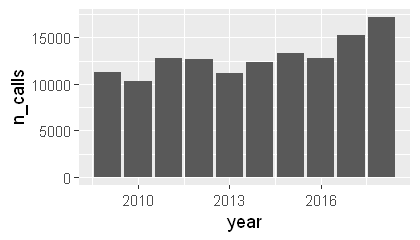

In [20]:
dt = cc[, .(n_calls=.N), keyby=.(year=year(date))]
options(repr.plot.width=3.5, repr.plot.height=2)
dt %>%
    ggplot(aes(x = year, y = n_calls)) +
    geom_bar(stat="identity")

## Number of Words For Each Transcript

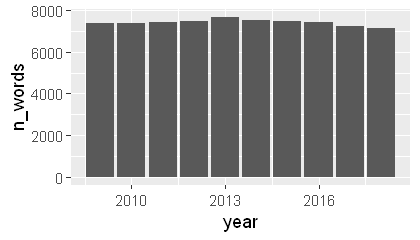

In [23]:
dt = cc[, .(n_words=mean(n_words)), keyby=.(year=year(date))]
dt %>%
    ggplot(aes(x = year, y = n_words)) +
    geom_bar(stat="identity")

# Deprecated

## idx-cst

In [68]:
ld(comp_idx_prof, path=WRDS_DOWNLOAD_DIR)
ld(comp_idx_cst, path=WRDS_DOWNLOAD_DIR)
ld(ciq_gvkey, path=WRDS_DOWNLOAD_DIR)
ld(ciq_ticker, path=WRDS_DOWNLOAD_DIR)

-comp_idx_prof- loaded  (0.01 secs)
-comp_idx_cst- loaded  (0.05 secs)
-ciq_gvkey- loaded  (0.14 secs)
-ciq_ticker- loaded  (9.96 secs)


In [40]:
comp_idx_prof[1]

conm,gvkeyx,idx13key,idxcstflg,idxstat,indexcat,indexgeo,indexid,indextype,indexval,spii,spmi,tic,tici
S&P Industrials-Wed,000001,0000000000000,N,A,S&P,USA,500,LGCAP,000000000,NA,NA,I0001,I0001


In [41]:
comp_idx_cst[1]

gvkey,iid,gvkeyx,from,thru
001004,01,030824,1994-10-01,NA


In [23]:
ciq_gvkey[gvkey=='001040']

companyid,gvkey,startdate,enddate,companyname
115281868,001040,NA,NA,AMF Inc.


In [42]:
ciq_gvkey[1]

companyid,gvkey,startdate,enddate,companyname
18507,235716,NA,NA,2M Invest A/S


In [43]:
ciq_ticker[1]

companyid,ticker,startdate,enddate,companyname
18507,1026283,2005-01-29,2004-12-16,2M Invest A/S


In [96]:
ciq_gvkey_agg = ciq_gvkey[, 
    .(startdate=ifelse(is.na(startdate), NA_real_, min(startdate)),
      enddate=ifelse(is.na(enddate), NA_real_, max(enddate))), 
    keyby=.(gvkey, companyname)]

idx_cst = unique(comp_idx_cst[comp_idx_prof[, .(idxnm=conm, gvkeyx)], on=.(gvkeyx), nomatch=0
    ][, .(idxnm, gvkeyx, gvkey, iid)])[ciq_gvkey_agg,
    on=.(gvkey), nomatch=0
    ][order(idxnm, gvkey, iid), 
      .(idxnm, gvkeyx, companyname, gvkey, iid, startdate, enddate)] %>% unique()
idx_cst[1]

idxnm,gvkeyx,companyname,gvkey,iid,startdate,enddate
Banks Composite,000931,AmSouth Bancorporation,001619,01,NA,NA


In [97]:
# first we only focus on SP500
sp500_cst = idx_cst[
    idxnm=='S&P 500 Comp-Ltd', 
    .(companyname, gvkey, iid, startdate, enddate)
    ][order(gvkey, iid)]
fwrite(sp500_cst, str_c(DATA_DIR, '/sp500_cst.csv'))

In [98]:
sp500_cst[1:3]

companyname,gvkey,iid,startdate,enddate
ACF Industries LLC,001010,01,NA,NA
CommScope Connectivity LLC,001013,01,NA,NA
AMF Inc.,001040,01,NA,NA


## firm-id

In [3]:
library = 'ciq'
dataset = 'wrds_cusip' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_cusip <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_cusip))

ciq_cusip[1]
sv(ciq_cusip, path=WRDS_DOWNLOAD_DIR)

[1] "wrds_cusip: 1597251"

companyid,cusip,startdate,enddate,companyname
18507,K9682F134,2010-01-24,2010-01-30,2M Invest A/S


-ciq_cusip- saved  (3.55 secs)


In [4]:
library = 'ciq'
dataset = 'wrds_gvkey' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_gvkey <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_gvkey))

ciq_gvkey[1]
sv(ciq_gvkey, path=WRDS_DOWNLOAD_DIR)

[1] "wrds_gvkey: 111883"

companyid,gvkey,startdate,enddate,companyname
18507,235716,NA,NA,2M Invest A/S


-ciq_gvkey- saved  (0.47 secs)


In [5]:
library = 'ciq'
dataset = 'wrds_ticker' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_ticker <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_ticker))

ciq_ticker[1]
sv(ciq_ticker, path=WRDS_DOWNLOAD_DIR)

[1] "wrds_ticker: 3219756"

companyid,ticker,startdate,enddate,companyname
18507,1026283,2005-01-29,2004-12-16,2M Invest A/S


-ciq_ticker- saved  (6.88 secs)


In [101]:
library = 'comp'
dataset = 'company' # firm names

query = sprintf("select * from %s.%s", library, dataset)
res <- dbSendQuery(wrds, query)
ciq_company <- setDT(dbFetch(res, n=-1)); dbClearResult(res)
sprintf('%s: %s', dataset, nrow(ciq_company))

ciq_company[1]
sv(ciq_company, path=WRDS_DOWNLOAD_DIR)

[1] "company: 47585"

conm,gvkey,add1,add2,add3,add4,addzip,busdesc,cik,city,conml,costat,county,dlrsn,ein,fax,fic,fyrc,ggroup,gind,gsector,gsubind,idbflag,incorp,loc,naics,phone,prican,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
A & E PLASTIK PAK INC,001000,NA,NA,NA,NA,NA,NA,NA,NA,A & E Plastik Pak Inc,I,NA,09,NA,NA,USA,12,NA,NA,NA,NA,D,NA,USA,NA,NA,NA,NA,01,3089,325,978,NA,NA,0,NA,1978-06-30,NA


-ciq_company- saved  (1.11 secs)


## read factiva html

### define parse func

In [222]:
# library
library(xml2)

# file_paths_2xxx 
years = 2002:2018
for (year in years) {
    assign(str_c('file_paths_', year), list.files(str_c(DATA_DIR, "factiva-transcripts/", year), pattern='.html', full=T))
}


parse_one_page <- function(html_path) {
    output = list()
    page = read_html(html_path)
    articles = xml_find_all(page, './/div[@id="contentWrapper"]//div[contains(@id, "article-")]')
    summary_table = xml_find_all(page, './/table[@id="oddEvenPreview"]')
    
    # check: most page should contain 100 articles
    if (length(articles) != 100) {
        print(paste('this page contains less than 100 articles,', html_path))
    }
    # check: page should contain "search summary" table
    if (length(summary_table) != 1) {
        print(paste('this page has no summary table,', html_path))
    }
    
    # loop through every article,
    # creating one obs for each article
    for (i in 1:length(articles)) {
        obs = list()
        article = articles[i]

        # title
        # check: each article should has exactly one title
        title = xml_find_all(article, './/div[@id="hd"]//span[@class="enHeadline"]') %>% xml_text()
        if (length(title) != 1) {
            print(paste("title parse error at i=", i, ',', html_path))
        }
        
        # meta
        # time
        # check: meta should have 6 (or 7, with time) elements
        meta = xml_find_all(article, './/div[not(@*)]') %>% xml_text() 
        if (length(meta) == 7) {
            time = str_extract(meta, '\\d+:\\d+ ?(AM|PM)') %>% na.omit()
            if (length(time)>0 & time == meta[3]) {
                time = as.ITime(fast_strptime(time, '%H:%M %p'))
                obs$time = time
                meta = meta[-3]
            }
        } else if (!(length(meta) %in% c(6, 7))) {
            print(str_c('meta parse error', meta, html_path, sep=', '))
        }
        
        # id
        # id is unique for every article
        id = xml_attr(article, "id")
        
        # n_words
        # check: n_words should be an integer
        n_words = str_match(meta[1], '(\\d+) +words')[2]
        if (length(n_words) == 0) {
            cat('n_words parse error,', meta, '\n')
        } else {n_words = as.integer(n_words)}
        
        # date
        # check: date is not NA
        date = dmy(meta[2])
        if (is.na(date)) {
            cat('date parse error,', meta, '\n')
        }
        
        # source
        source = meta[3]
        
        # source2
        source_code = meta[4]
        
        # language
        language = meta[5]
        
        # content
        # check: if content can't be found , report and let content=NA 
        content = xml_find_all(article, './/p[contains(@class, "articleParagraph")]') %>% 
            xml_text() %>%
            str_replace_all('\\s+', ' ') %>%
            str_replace_all('  +', ' ') %>%
            str_c(collapse='\n') %>%
            str_replace_all('\n\n+', '\n')
#         if (is.na(content)) {
#             print(paste('content is NA,', html_path, title))
        if (length(content) == 0) {
            print(paste('there is no content,', html_path, title))
            content = NA_character_
        }
        
        
        # add fields to obs
        obs$title = title
        obs$n_words = n_words
        obs$date = date
        obs$source = source
        obs$source_code = source_code
        obs$language = language
        obs$id = id
        obs$content = content
        
        # append obs to output
        output[[i]] = obs
    }
    
    rbindlist(output, fill=T)   
}

parse_many_pages <- function(html_paths) {
    print(paste('start at', now()))
    output = list()
    for (i in 1:length(html_paths)) {
        print(paste('processing', i, '/', length(html_paths), now()))
        one_page = parse_one_page(html_paths[i])
        output[[i]] = one_page
    }
    rbindlist(output, fill=T)
}

### unit-test

In [ ]:
test_file_path = "C:/Users/rossz/OneDrive/CC/data/factiva-transcripts/2003/Factiva-2003-earnings-conference-call-4801-4900.html"
page = read_html(test_file_path)
articles = xml_find_all(page, './/div[@id="contentWrapper"]//div[contains(@id, "article-")]')

article = articles[18]
meta = xml_find_all(article, './/div[not(@*)]') %>% xml_text() 
if (length(meta) == 7) {
    time = str_extract(meta, '\\d+:\\d+ ?(AM|PM)') %>% na.omit()
    if (length(time)>0 & time == meta[3]) {
        obs$time = time
        meta = c(meta[-3])
    }
}

# content = xml_find_all(articles[23], './/p[contains(@class, "articleParagraph")]') %>% xml_text()
# content = str_c(content, collapse='\n')
# length(content)

# title = xml_find_all(article, './/div[@id="hd"]//span[@class="enHeadline"]') %>% xml_text()
# title

### read article

In [ ]:
# checked
cc_2018 = parse_many_pages(file_paths_2018)
sv(cc_2018)

# checked
cc_2017 = parse_many_pages(file_paths_2017)
sv(cc_2017)

# checked
cc_2016 = parse_many_pages(file_paths_2016)
sv(cc_2016)

# checked
cc_2015 = parse_many_pages(file_paths_2015)
sv(cc_2015)

# checked
cc_2014 = parse_many_pages(file_paths_2014)
sv(cc_2014)

# checked
cc_2013 = parse_many_pages(file_paths_2013)
sv(cc_2013)

# checked
cc_2012 = parse_many_pages(file_paths_2012)
sv(cc_2012)

# checked
cc_2011 = parse_many_pages(file_paths_2011)
sv(cc_2011)

# checked
cc_2010 = parse_many_pages(file_paths_2010)
sv(cc_2010)

# checked
cc_2009 = parse_many_pages(file_paths_2009)
sv(cc_2009)

# checked
cc_2008 = parse_many_pages(file_paths_2008)
sv(cc_2008)

# checked
cc_2007 = parse_many_pages(file_paths_2007)
sv(cc_2007)

# checked
cc_2006 = parse_many_pages(file_paths_2006)
sv(cc_2006)

# checked
cc_2005 = parse_many_pages(file_paths_2005)
sv(cc_2005)

# checked
cc_2004 = parse_many_pages(file_paths_2004)
sv(cc_2004)

### checked
cc_2003 = parse_many_pages(file_paths_2003)
sv(cc_2003)

### checked
cc_2002 = parse_many_pages(file_paths_2002)
sv(cc_2002)

In [ ]:
# merge all
ld(cc_2018);ld(cc_2017);ld(cc_2016);ld(cc_2015);ld(cc_2014);ld(cc_2013)
ld(cc_2012);ld(cc_2011);ld(cc_2010);ld(cc_2009);ld(cc_2008);ld(cc_2007)
ld(cc_2006);ld(cc_2005);ld(cc_2004);ld(cc_2003);ld(cc_2002)

cc = rbindlist(list(cc_2018, cc_2017, cc_2016, cc_2015, cc_2014, cc_2013, cc_2012, cc_2011, cc_2010, cc_2009, cc_2008, cc_2007, cc_2006, cc_2005, cc_2004, cc_2003, cc_2002), fill=T) %>% unique(by='id')

sv(cc)

In [5]:
ld(cc_2018)

-cc_2018- loaded  (4.92 secs)


## parse factiva 

### remove end claim

In [225]:
# remove the Thomson claim at the end of each cc transcript
# It may include 4 parts
# part I:
#    (Thomson Financial Serviecs | CCBN) reserves the right to...
#    without obligation to notify any person of such changes.
# part II:
#    In the conference calls upon which...
#    statements wil be realized.
# part III:
#    THE INFORMATION CONTAINED IN EVENT...
#    INVESTMENT OR OTHER DECISIONS.
# part IV:
#    Copyright: Content...
#    transcript for purposes of litigation.
# part V:
#    EDITOR:...the interpreter was provided by the company sponsoring this event'
# part VI:
#    COPYRIGHT 2002 BY FDCH-eMedia...THE EXPRESS WRITTEN AUTHORITY OF FDCH-eMedia, Inc.
# PART VII:
#    The information contained in this transcript that addresses future results...
# PART 8:
#    This press release contains certain statements related to future results, our intentions...(end)
# Part 9:
#    Forward-looking statements, including, without limitation, those relating to our future business prospects...(end)

clean_text <- function(text) {
    str_replace_all(text, '(Thomson|CCBN).+reserves the right to[\\s\\S]+without obligation to notify any person of such changes', '') %>%
        str_replace_all('In the conference calls upon[\\s\\S]+statements will be realized', '') %>%
        str_replace('THE INFORMATION CONTAINED IN EVENT[\\s\\S]+INVESTMENT OR OTHER DECISIONS', '') %>%
        str_replace_all('(?i)Copyright: Content[\\s\\S]+?transcript for purposes of litigation', '') %>%
        str_replace_all('EDITOR.*', '') %>%
        str_replace_all('(?i)copyright.+all rights reserved', '') %>%
        str_replace_all('COPYRIGHT.+Inc\\.?', '') %>%
        str_replace_all('(The information contained in this transcript that addresses future results|The forward-looking information and statement).+', '') %>%
        str_replace_all('(?i)(This press release contains certain statements related to future results|This transcript contains certain "forward-looking statements").+', '') %>%
        str_replace_all('(?i)Forward-looking statements, including, without limitation, those relating to our future business prospects.+', '') %>%
        str_replace_all('\n\n+', '\n')
}

In [226]:
system.time({
    cc_1 = cc[, .(date, title, n_words, source, source_code, id, content=clean_text(content))]
    nrow(cc_1)
    sv(cc_1)
})

-cc_1- saved  (6.56 mins)


   user  system elapsed 
2105.04   77.60 2183.16 

In [230]:
temp = cc_1[, .(date=date[1], n=.N), keyby=.(cont=str_sub(content, -100))
    ][!str_detect(cont, '(?i)(disconnect|thank|appreciate|wonderful|nice|great|pleasant|participation|day)')
    ][order(-n)]
nrow(temp)
temp

[1] 3160

cont,date,n
present on the live call. The interpreter was provided by the Company sponsoring this Event. [. . .],2017-05-10,34
"ommission (""SEC"") and are available on the SEC's website at www.sec.gov[http://www.sec.gov]. [. . .]",2018-07-26,17
reciate your interest in Amazon.com and look forward to talking with you again next quarter. [. . .],2018-02-01,11
will not be transcribed because the replay audio has expired. UNIDENTIFIED: [. . . .] [.],2002-04-15,9
e information on BW LPG is available online at www.bwlpg.com[http://www.bwlpg.com]. Goodbye. [. . .],2018-11-21,8
on to update these forward-looking statements to reflect subsequent events or circumstances. [. . .],2017-11-16,7
t makes on related subjects in its reports filed with the SEC and in its press releases. [. . .],2007-08-21,7
in the Appendix or on our website at www.conocophillips.com[http://www.conocophillips.com]. [. . .],2011-04-27,6
and consumer confidence affect the retail sale of products for which we sell our components. [. . .],2013-11-01,6
ement makes on related subjects in its reports filed with the SEC and in its press releases. [. . .],2009-05-19,6


### split MD/QA

In [ ]:
# split the text into 'MD' and 'QA'
# 'MD' starts with 'Presentation'
# 'QA' starts with 'Questions and Answers'
#     (Presentation\\n[\\s\\S]+?)(Questions and Answers\\n[\\s\\S]+)

split_md_qa <- function(text) {
    text_match = str_match(text, '(Presentation\\n[\\s\\S]+?)(Questions and Answers\\n[\\s\\S]+)')
    md = text_match[,2]
    qa = text_match[,3]
    md[is.na(md)] = text[is.na(md)]
    md[is.na(md)] = ''
    qa[is.na(qa)] = ''
    
    len_md = str_length(md)
    len_qa = str_length(qa)
    list(md, qa, len_md, len_qa)
}

cc_2 = cc_1[year(date) %between% c(2011,2018)
    ][, {
        re = split_md_qa(content)
        list(date=date, title=title, id=id, n_words=n_words, 
             source=source, source_code=source_code,
             md=re[[1]], qa=re[[2]], len_md=re[[3]],
             len_qa=re[[4]])
    }]
sv(cc_2)

Warning message:
"Removed 3 rows containing non-finite values (stat_bin)."

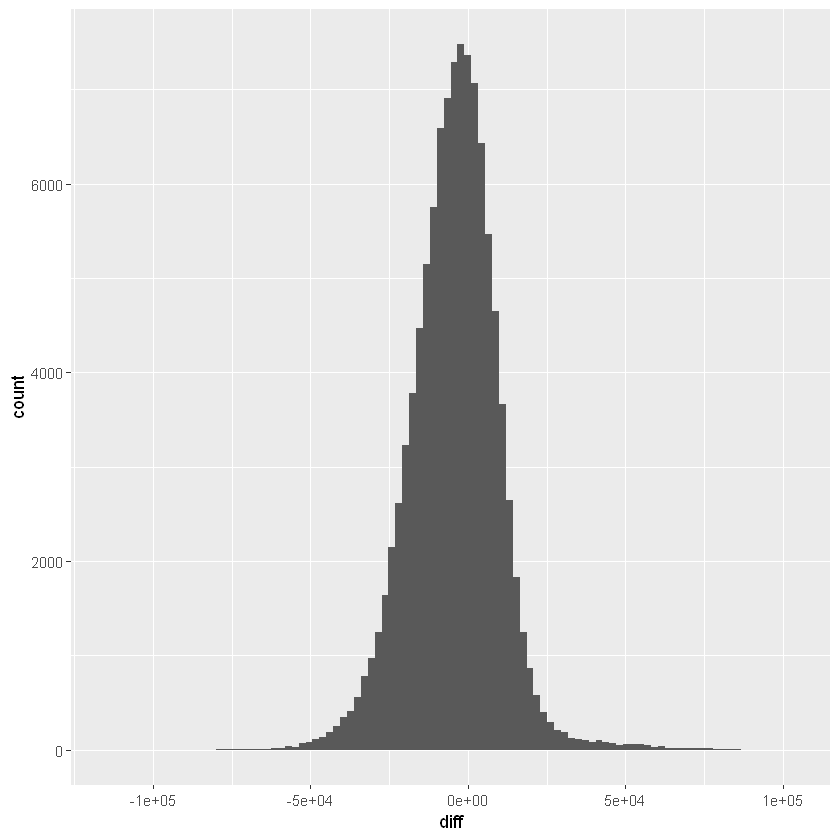

In [244]:
# dt
cc_2[, .(diff = len_md-len_qa)] %>%
    ggplot(aes(diff)) +
    geom_histogram(bins = 100)

## match `firm_name`

### create lookup table

In [337]:
ld(cc_2)
ld(crsp_firm_names, force=T)
crsp_firm_names[1]

-cc_2- already exists, will NOT load again!  (0 secs)
-crsp_firm_names- loaded  (0.22 secs)


permno,namedt,nameendt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,tsymbol,naics,primexch,trdstat,secstat,permco,compno,issuno,hexcd,hsiccd,cusip
10000,1986-01-07,1986-12-03,10,3,3990,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,OMFGA,NA,Q,A,R,7952,60007905,10396,3,3990,68391610


In [338]:
crsp_firm_names = unique(
    crsp_firm_names[year(nameendt)>=2010
                  ][, .(comnam, cusip, ncusip, ticker, start_date=namedt)], 
    by=c('comnam', 'cusip', 'ncusip', 'ticker'))

unique_crsp_firm_names = crsp_firm_names[, unique(comnam)]

cat(str_c('Unique crsp_firm_names: ', 
          length(unique_crsp_firm_names), '\n'))

Unique crsp_firm_names: 10478


In [331]:
nrow(crsp_firm_names)
crsp_firm_names[str_detect(comnam, 'WESTERN AREAS')]

[1] 15516

comnam,cusip,ncusip,ticker


### extract `firm_name`

In [332]:
# extract `fiscal_year`, `fiscal_qtr`, `name`
clean_title <- function(title) {
    
    # full_year: True if title contains "full year"; Fasle otherwise
    full_year_regex = regex('&? ?\\(?/?(annual|full year|full-year|full year and|full year|and full year|full year|FY|Year End|YearEnd|fiscal year|fiscal year end|Shortened Fiscal Year End) ?&?\\)?', ignore_case=T)
    first_qtr_regex = regex('(First Quarter|1Q)', ignore=T)
    half_year_regex = regex('&? ?(half year|H1|1H|HY)', ignore_case=T)
    nine_months_regex = regex('&? ?(nine months?|9M)', ignore_case=T)
    fourth_qtr_regex = regex('fourth quarter', ignore_case=T)
    fiscal_regex = regex('fiscal', ignore_case=T)
    preliminary_regex = regex('preliminary', ignore_case=T)
    calendar_regex = regex('\\(?Calendar\\)?', ignore_case=T)
    interim_regex = regex('Interim', ignore=T)
    
    replace_qtr_regex = regex('(Q\\d{1}|\\dQ)( and| &|, )?(Q\\d{1})?( and| &|, )?(Q\\d{1})?')
    replace_year_regex = regex('(Interim)?20\\d{2}(\\.\\d+)?/?\\\\?(20)?(\\d{2})?')
    replace_others_regex = regex('Results', ignore=T)
    
    is_first_qtr = str_detect(title, first_qtr_regex)
    is_full_year = str_detect(title, full_year_regex)
    is_half_year = str_detect(title, half_year_regex)
    is_nine_months = str_detect(title, nine_months_regex)
    is_fourth_qtr = str_detect(title, fourth_qtr_regex)
    is_fiscal = str_detect(title, fiscal_regex)
    is_preliminary = str_detect(title, preliminary_regex)
    is_calendar = str_detect(title, calendar_regex)
    is_interim = str_detect(title, interim_regex)
    
    name = str_replace_all(title, full_year_regex, '') %>%
        str_replace_all(fiscal_regex, '') %>%
        str_replace_all(nine_months_regex, '') %>%
        str_replace_all(half_year_regex, '') %>%
        str_replace_all(fourth_qtr_regex, '') %>%
        str_replace_all(preliminary_regex, '') %>%
        str_replace_all(calendar_regex, '') %>%
        str_replace_all(interim_regex, '') %>%
        str_replace_all(first_qtr_regex, '') %>%
        str_replace_all(
            regex('(Sales &)? ?Earnings (Conference )?Call - Final',                               ignore_case=T), '')

    year = lapply(str_extract_all(name, '20\\d{2}/?\\\\?(20)?(\\d{2})?'), unique) %>%
           sapply(str_c, collapse=',')
    qtr = lapply(str_extract_all(name, '(Q\\d{1}|\\d{1}Q)'), unique) %>%
          sapply(str_c, collapse=',')
    
    name = str_replace_all(name, replace_year_regex, '') %>%
        str_replace_all(replace_qtr_regex, '') %>%
        str_replace_all(replace_others_regex, '') %>%
        str_replace_all('  +', ' ') %>%
        str_trim()
    
    list(firm_name=name, fiscal_qtr=qtr, fiscal_year=year, 
         is_fiscal=is_fiscal, is_full_year=is_full_year, 
         is_half_year=is_half_year, is_nine_months=is_nine_months,
         is_preliminary=is_preliminary, is_calendar=is_calendar,
         is_interim=is_interim, is_first_qtr=is_first_qtr,
         is_fourth_qtr=is_fourth_qtr)
}

# cc_firm_names: a data.table containing parsed title
cc_firm_names = cc_2[, .(date, title)
    ][, c('firm_name', 'fiscal_qtr', 'fiscal_year',
          'is_fiscal', 'is_full_year', 'is_half_year', 
          'is_nine_months', 'is_preliminary', 'is_calendar',
          'is_interim', 'is_first_qtr',
          'is_fourth_qtr') := (clean_title(title))]
cc_firm_names[1]

# unique_cc_firm_names: characters containing unique cc_firm_names
unique_cc_firm_names = na.omit(cc_firm_names[, unique(firm_name)])
cat(str_c('Unique cc_firm_names: ', 
          length(unique_cc_firm_names), '\n'))

date,title,firm_name,fiscal_qtr,fiscal_year,is_fiscal,is_full_year,is_half_year,is_nine_months,is_preliminary,is_calendar,is_interim,is_first_qtr,is_fourth_qtr
2018-12-31,Q4 2018 RCI Hospitality Holdings Inc Earnings Call - Final,RCI Hospitality Holdings Inc,Q4,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


Unique cc_firm_names: 15600


Exceptions to be dealt with:
- "1Q14 Lexmark International, Inc. Earnings Conference Call - Final"
- "Q2 2104 Air Transport Services Group, Inc. Earnings Conference Call - Final"

In [339]:
crsp_firm_names[str_detect(comnam, regex('Arch Capital Group', ignore=T))]

comnam,cusip,ncusip,ticker,start_date
ARCH CAPITAL GROUP LTD NEW,G0450A10,G0450A10,ACGL,2006-06-30


In [320]:
cc_firm_names[str_detect(title, regex('AGL', ignore=T))]
# cc_firm_names[is_calendar==T]

date,title,firm_name,fiscal_qtr,fiscal_year,is_fiscal,is_full_year,is_half_year,is_nine_months,is_preliminary,is_calendar,is_interim,is_first_qtr,is_fourth_qtr
2018-12-11,Q3 2018 American Eagle Outfitters Inc Earnings Call - Final,American Eagle Outfitters Inc,Q3,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-11-01,Q3 2018 Eagle Pharmaceuticals Inc Earnings Call - Final,Eagle Pharmaceuticals Inc,Q3,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-10-30,Q2 2019 Eagle Materials Inc Earnings Call - Final,Eagle Materials Inc,Q2,2019,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-10-25,Q3 2018 Agnico Eagle Mines Ltd Earnings Call - Final,Agnico Eagle Mines Ltd,Q3,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-10-18,Q3 2018 Eagle Bancorp Inc Earnings Call - Final,Eagle Bancorp Inc,Q3,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-08-29,Q2 2018 American Eagle Outfitters Inc Earnings Call - Final,American Eagle Outfitters Inc,Q2,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-11-14,Q3 2018 Eagle Point Credit Company Inc Earnings Call - Final,Eagle Point Credit Company Inc,Q3,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-08-14,Q2 2018 Eagle Point Credit Company Inc Earnings Call - Final,Eagle Point Credit Company Inc,Q2,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-08-09,Q2 2018 Global Eagle Entertainment Inc Earnings Call - Final,Global Eagle Entertainment Inc,Q2,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2018-08-07,Q2 2018 Eagle Pharmaceuticals Inc Earnings Call - Final,Eagle Pharmaceuticals Inc,Q2,2018,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


### start match

In [128]:
system.time({
options('sd_num_thread'=8)
    
firm_name_match_lv = amatch(
    toupper(unique_cc_firm_names), 
    toupper(unique_crsp_firm_names), 
    method='lv', maxDist=Inf, 
    nthread=8)
sv(firm_name_match_lv)

# firm_name_match_lcs = amatch(
#     toupper(unique_cc_firm_names), 
#     toupper(unique_crsp_firm_names), 
#     method='lcs', maxDist=Inf, 
#     nthread=8)
# sv(firm_name_match_lcs)
    
# firm_name_match_cosine = amatch(
#     toupper(unique_cc_firm_names), 
#     toupper(unique_crsp_firm_names), 
#     method='cosine', maxDist=Inf, 
#     nthread=8)
# sv(firm_name_match_cosine)
    
})

-firm_name_match_lv- saved  (0.01 secs)


   user  system elapsed 
 184.53    0.04  101.22 

We experiment with some distance metircs and find the `lv` is the best

In [109]:
matched_names_lv = data.table(
    firm_names=unique_cc_firm_names,
    crsp_firm_name_titlecase = tolower(unique_crsp_firm_names) %>%
        toTitleCase() %>% `[`(firm_name_match_lv),
    crsp_firm_name=unique_crsp_firm_names[firm_name_match_lv])
matched_names_lv[1:5]
fwrite(matched_names_lv, './matched_names_lv.csv')

firm_names,crsp_firm_name_titlecase,crsp_firm_name
RCI Hospitality Holdings Inc,Rci Hospitality Holdings Inc,RCI HOSPITALITY HOLDINGS INC
ADDvantage Technologies Group Inc,Addvantage Technologies Grp Inc,ADDVANTAGE TECHNOLOGIES GRP INC
Bridgeline Digital Inc,Bridgeline Digital Inc,BRIDGELINE DIGITAL INC
CSP Inc,c s p Inc,C S P INC
Dynasil Corporation of America,Dynasil Corporation of America,DYNASIL CORPORATION OF AMERICA
